<div style="text-align: left; background-color:white; font-family: Trebuchet MS; color:red; padding: 12px; line-height:1.25;border-radius:1px; margin-bottom: 0em; text-align: center; font-size: 58px;border-style: solid;border-color: black solid;"> Demo Chatbot for CAI website </div>

<center>
    <img src='https://img.freepik.com/free-vector/chat-bot-concept-illustration_114360-5522.jpg?size=626&ext=jpg&ga=GA1.1.253247083.1693101812&semt=sph'>
</center>


<div style="border-radius:10px;
            border: black solid;
            adding: 15px;
            background-color:black;
            font-size:120%;
            text-aling: left">
<h3 style:'border:0; border-radius: 15px; color: white'><center> Project steps</center></h3>

_________________________________________________________________________
    
1. Load the data<br>
2. EDA and analyze the data for more insights
3. Split the data into train, test and validation datasets<br>
4. Load BERT Pretrained model and tokenizer<br>
5. Transform the data to numerical format<br>
6. Train BERT Pretrained model on our custome dataset<br>
7. Evaluate the model <br>
8. Save the model<br>
9. Finally, Load The model and start the conversation

<a id="2"></a>
## <b><span style='color:#B21010'></span>Import Necessaries</b>

In [1]:
# ! pip install -U accelerate
# ! pip install -U transformers
# !pip install xformers

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [14]:
import json
import numpy as np
import pandas as pd
import random
from matplotlib import pyplot as plt
import seaborn as sns
from wordcloud import WordCloud,STOPWORDS
import missingno as msno

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

from keras.preprocessing import text
import keras
from keras.models import Sequential
from keras.layers import Dense,Embedding,LSTM,Dropout
from keras.callbacks import ReduceLROnPlateau

from tensorflow.keras.preprocessing.sequence import pad_sequences
import nltk
from nltk import word_tokenize
from nltk.stem import PorterStemmer

import torch
from torch.utils.data import Dataset

from transformers import AutoTokenizer, TFAutoModelForSequenceClassification
from transformers import pipeline
from transformers import DistilBertTokenizerFast
from transformers import BertForSequenceClassification, BertTokenizerFast
from transformers import TFDistilBertForSequenceClassification, TFTrainer, TFTrainingArguments
from transformers import BertTokenizer, TFBertForSequenceClassification, BertConfig
from transformers import TrainingArguments, Trainer

ModuleNotFoundError: No module named 'seaborn'

<a id="3"></a>
## <b><span style='color:#B21010'></span> EDA + Vis</b>

<a id=""></a>
### <b><span style='color:#B21010'></span> Load the data</b>

In [13]:
def load_json_file(filename):
    with open(filename) as f:
        file = json.load(f)
    return file

filename = '/content/intents.json'

intents = load_json_file(filename)

FileNotFoundError: [Errno 2] No such file or directory: '/content/intents.json'

In [ ]:
def create_df():
    df = pd.DataFrame({
        'Pattern' : [],
        'Tag' : []
    })
    
    return df

df = create_df()
df

</span> Extract Info from the Json data file and Store it in dataframe</b>

In [6]:
def extract_json_info(json_file, df):

    for intent in json_file['intents']:

        for pattern in intent['patterns']:

            sentence_tag = [pattern, intent['tag']]
            df.loc[len(df.index)] = sentence_tag

    return df

df = extract_json_info(intents, df)
df.head()

,Pattern,Tag
0,Hi,greeting
1,How are you?,greeting
2,Is anyone there?,greeting
3,Hello,greeting
4,Good day,greeting


In [7]:
df2 = df.copy()
df2.head()

,Pattern,Tag
0,Hi,greeting
1,How are you?,greeting
2,Is anyone there?,greeting
3,Hello,greeting
4,Good day,greeting



</span> Check the shape of the dataset</b>

In [8]:
def print_shape_df(df, ds_name="df"):
    print(f"{ds_name} dataset has {df.shape[0]} rows and {df.shape[1]} columns")

print_shape_df(df, "Chatbot")

Chatbot dataset has 414 rows and 2 columns


<a id="3.4"></a>
### <b><span style='color:#B21010'></span> Display information about the dataset</b>

In [9]:
def print_dfInfo(df, ds_name="df"):
    print(f"The info of {ds_name} dataset\n")
    print(df.info())

print_dfInfo(df, "Chatbot")

The info of Chatbot dataset

<class 'pandas.core.frame.DataFrame'>
Int64Index: 414 entries, 0 to 413
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Pattern  414 non-null    object
 1   Tag      414 non-null    object
dtypes: object(2)
memory usage: 9.7+ KB
None


<a id="3.5"></a>
### <b> <span style='color:#B21010'></span> Display Number of Classes</b>

In [10]:
def num_classes(df, target_col, ds_name="df"):
    print(f"The {ds_name} dataset has {len(df[target_col].unique())} classes")

num_classes(df, 'Tag', "Chatbot")

The Chatbot dataset has 39 classes


<a id="3.6"></a>
### <b> <span style='color:#B21010'></span> Check the null values in the dataset</b>

In [11]:
def check_null(df, ds_name='df'):
    print(f"Null Values in each col in the {ds_name} dataset:\n")
    print(df.isnull().sum())

check_null(df, "Chatbot")

Null Values in each col in the Chatbot dataset:

Pattern    0
Tag        0
dtype: int64


<a id="3.8"></a>
### <b> <span style='color:#B21010'></span> Visualize the distrbution of our Classes</b>

In [13]:
def count_plot(x, df, title, xlabel, ylabel, width, height, order = None, rotation=False, palette='winter', hue=None):
    ncount = len(df)
    plt.figure(figsize=(width,height))
    ax = sns.countplot(x = x, palette=palette, order = order, hue=hue)
    plt.title(title, fontsize=20)
    if rotation:
        plt.xticks(rotation = 'vertical')
    plt.xlabel(xlabel, fontsize=25)
    plt.ylabel(ylabel, fontsize=25)

    ax.yaxis.set_label_position('left')
    for p in ax.patches:
        x=p.get_bbox().get_points()[:,0]
        y=p.get_bbox().get_points()[1,1]
        ax.annotate('{:.1f}%'.format(100.*y/ncount), (x.mean(), y),
                ha='center', va='bottom') # set the alignment of the text

    plt.show()

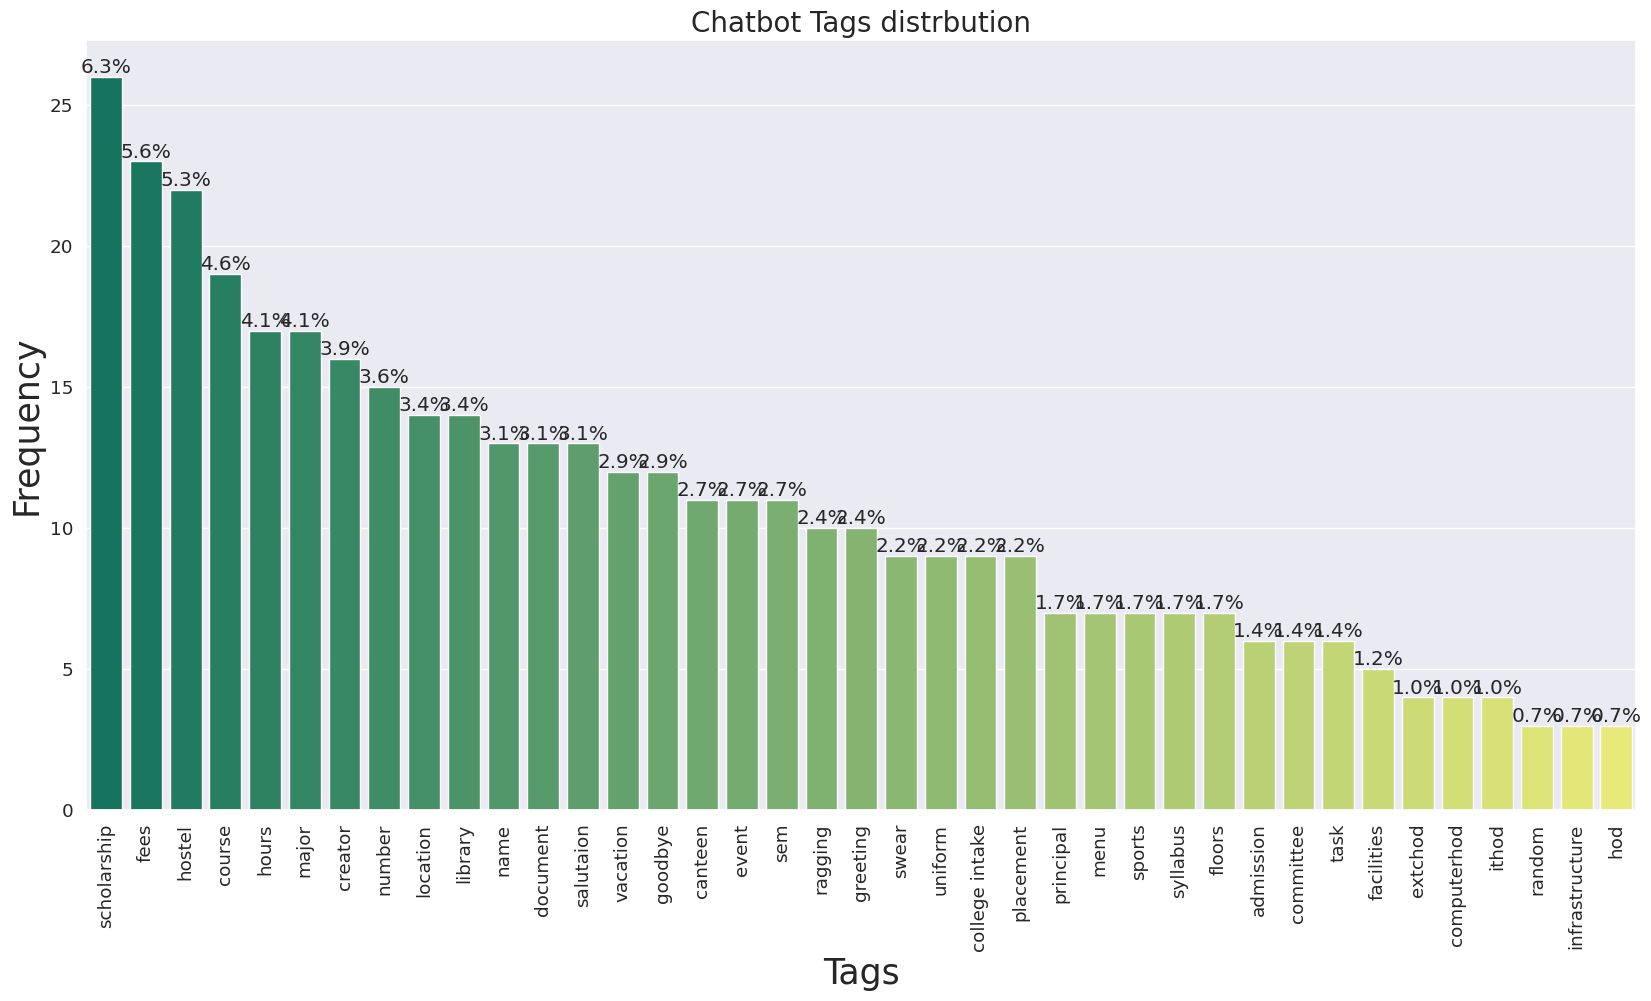

In [14]:
sns.set(font_scale = 1.2)
order = df['Tag'].value_counts().index
count_plot(df['Tag'], df, "Chatbot Tags distrbution", "Tags", "Frequency", 20,10, order=order,rotation=True, palette="summer")

In [15]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [16]:
stemmer = PorterStemmer()
ignore_words=['?', '!', ',', '.']

def preprocess_pattern(pattern):
    words = word_tokenize(pattern.lower())
    stemmed_words = [stemmer.stem(word) for word in words if word not in ignore_words]
    return " ".join(stemmed_words)

df['Pattern'] = df['Pattern'].apply(preprocess_pattern)

In [17]:
df.head()

,Pattern,Tag
0,hi,greeting
1,how are you,greeting
2,is anyon there,greeting
3,hello,greeting
4,good day,greeting


In [18]:
print(df['Pattern'].isnull().sum())

0


<a id="3.13"></a>
### <b> <span style='color:#B21010'></span> Visualize top words</b>

In [23]:
def get_corpus(series):
    words = []
    for text in series:
        for word in text.split():
            words.append(word.strip())
    return words

corpus = get_corpus(df.Pattern)
corpus[:5]

['hi', 'how', 'are', 'you', 'is']

In [24]:
print(f"dataset contains {len(corpus)} words")

dataset contains 1415 words


In [25]:
from collections import Counter
counter = Counter(corpus)
most_common = counter.most_common(10)
most_common = dict(most_common)
most_common

{'colleg': 79,
 'is': 75,
 'what': 63,
 'the': 54,
 'in': 39,
 'you': 38,
 'of': 36,
 'are': 29,
 'for': 26,
 'scholarship': 26}

In [26]:
def get_top_text_ngrams(corpus, n,g):
    vec = CountVectorizer(ngram_range=(1, 1)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

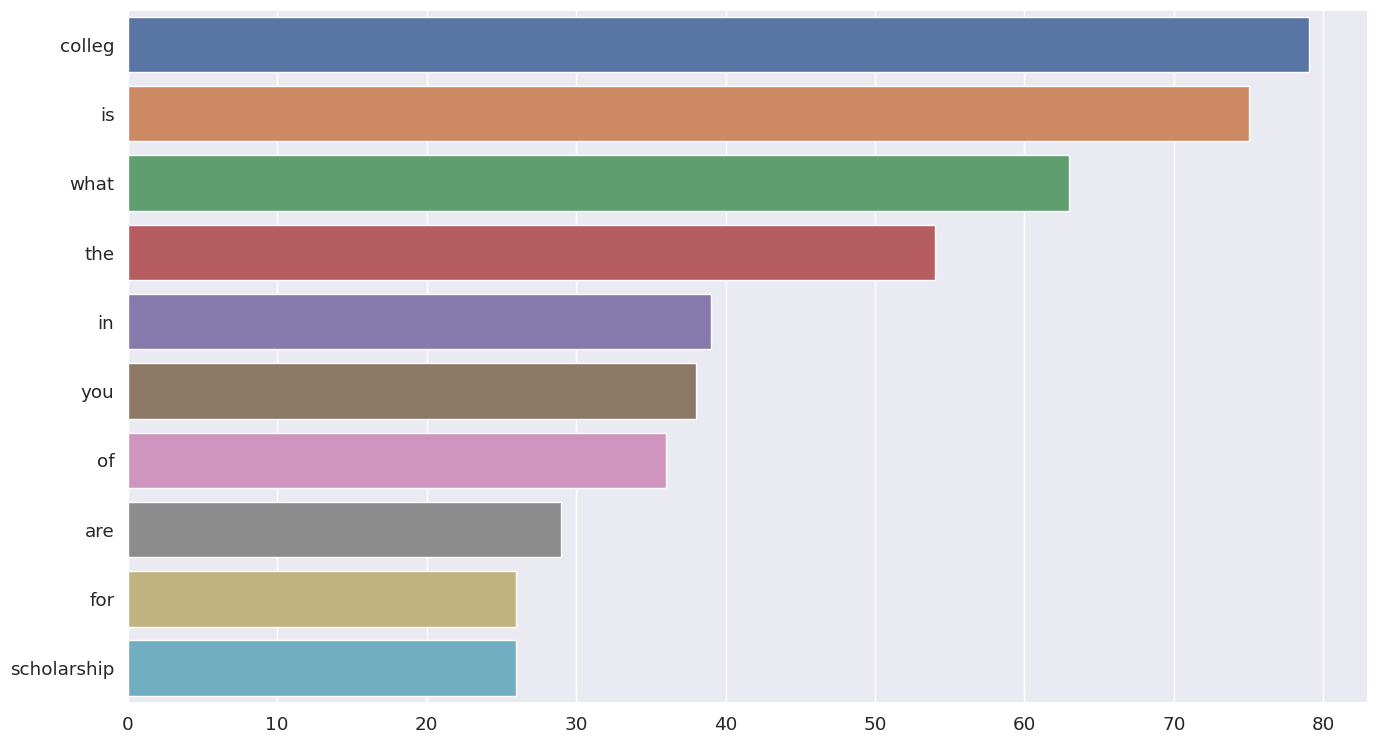

In [27]:
plt.figure(figsize = (16,9))
most_common_uni = get_top_text_ngrams(df.Pattern,10,1)
most_common_uni = dict(most_common_uni)
sns.barplot(x=list(most_common_uni.values()),y=list(most_common_uni.keys()));

<a id="4"></a>
## <b> <span style='color:#B21010'></span> Data Preprocessing</b>

In [28]:
df2.head()

,Pattern,Tag
0,Hi,greeting
1,How are you?,greeting
2,Is anyone there?,greeting
3,Hello,greeting
4,Good day,greeting


In [29]:
labels = df2['Tag'].unique().tolist()
labels = [s.strip() for s in labels]
labels

['greeting',
 'goodbye',
 'creator',
 'name',
 'hours',
 'number',
 'course',
 'major',
 'fees',
 'location',
 'hostel',
 'event',
 'document',
 'floors',
 'syllabus',
 'library',
 'infrastructure',
 'canteen',
 'menu',
 'placement',
 'ithod',
 'computerhod',
 'extchod',
 'principal',
 'sem',
 'admission',
 'scholarship',
 'facilities',
 'college intake',
 'uniform',
 'committee',
 'random',
 'swear',
 'vacation',
 'sports',
 'salutaion',
 'task',
 'ragging',
 'hod']

In [30]:
num_labels = len(labels)
id2label = {id:label for id, label in enumerate(labels)}
label2id = {label:id for id, label in enumerate(labels)}

In [31]:
id2label

{0: 'greeting',
 1: 'goodbye',
 2: 'creator',
 3: 'name',
 4: 'hours',
 5: 'number',
 6: 'course',
 7: 'major',
 8: 'fees',
 9: 'location',
 10: 'hostel',
 11: 'event',
 12: 'document',
 13: 'floors',
 14: 'syllabus',
 15: 'library',
 16: 'infrastructure',
 17: 'canteen',
 18: 'menu',
 19: 'placement',
 20: 'ithod',
 21: 'computerhod',
 22: 'extchod',
 23: 'principal',
 24: 'sem',
 25: 'admission',
 26: 'scholarship',
 27: 'facilities',
 28: 'college intake',
 29: 'uniform',
 30: 'committee',
 31: 'random',
 32: 'swear',
 33: 'vacation',
 34: 'sports',
 35: 'salutaion',
 36: 'task',
 37: 'ragging',
 38: 'hod'}

In [32]:
label2id

{'greeting': 0,
 'goodbye': 1,
 'creator': 2,
 'name': 3,
 'hours': 4,
 'number': 5,
 'course': 6,
 'major': 7,
 'fees': 8,
 'location': 9,
 'hostel': 10,
 'event': 11,
 'document': 12,
 'floors': 13,
 'syllabus': 14,
 'library': 15,
 'infrastructure': 16,
 'canteen': 17,
 'menu': 18,
 'placement': 19,
 'ithod': 20,
 'computerhod': 21,
 'extchod': 22,
 'principal': 23,
 'sem': 24,
 'admission': 25,
 'scholarship': 26,
 'facilities': 27,
 'college intake': 28,
 'uniform': 29,
 'committee': 30,
 'random': 31,
 'swear': 32,
 'vacation': 33,
 'sports': 34,
 'salutaion': 35,
 'task': 36,
 'ragging': 37,
 'hod': 38}

In [33]:
df2['labels'] = df2['Tag'].map(lambda x: label2id[x.strip()])
df2.head()

,Pattern,Tag,labels
0,Hi,greeting,0
1,How are you?,greeting,0
2,Is anyone there?,greeting,0
3,Hello,greeting,0
4,Good day,greeting,0


<a id="5"></a>
## <b> <span style='color:#B21010'></span> Split the data into train and test</b>

In [34]:
X = list(df2['Pattern'])
X[:5]

['Hi', 'How are you?', 'Is anyone there?', 'Hello', 'Good day']

In [35]:
y = list(df2['labels'])
y[:5]

[0, 0, 0, 0, 0]

In [36]:
X_train,X_test,y_train,y_test = train_test_split(X,y,random_state = 123)

<a id="6"></a>
## <b> <span style='color:#B21010'></span> Load BERT Pretrained model and Tokenizer</b>

In [37]:
model_name = "bert-base-uncased"
max_len = 256

tokenizer = BertTokenizer.from_pretrained(model_name,
                                          max_length=max_len)

model = BertForSequenceClassification.from_pretrained(model_name,
                                                      num_labels=num_labels,
                                                      id2label=id2label,
                                                      label2id = label2id)

tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


<a id="7"></a>
## <b><span style='color:#B21010'></span> Transform the data into numerical format</b>

In [38]:
train_encoding = tokenizer(X_train, truncation=True, padding=True)
test_encoding = tokenizer(X_test, truncation=True, padding=True)

In [39]:
full_data = tokenizer(X, truncation=True, padding=True)

<a id="8"></a>
## <b> <span style='color:#B21010'></span> Build Data Loader</b>


In [40]:
class DataLoader(Dataset):

    def __init__(self, encodings, labels):

        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):

        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):

        return len(self.labels)

In [41]:
train_dataloader = DataLoader(train_encoding, y_train)
test_dataloader = DataLoader(test_encoding, y_test)

In [42]:
fullDataLoader = DataLoader(full_data, y_test)

<a id="9"></a>
## <b><span style='color:#B21010'></span> Define Evaluation Metrcies</b>


In [43]:
def compute_metrics(pred):

    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='macro')
    acc = accuracy_score(labels, preds)

    return {
        'Accuracy': acc,
        'F1': f1,
        'Precision': precision,
        'Recall': recall
    }

<a id="10"></a>
## <b><span style='color:#B21010'></span> Define Training Arguments</b>


In [44]:
training_args = TrainingArguments(
    output_dir='./output',
    do_train=True,
    do_eval=True,
    num_train_epochs=100,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=16,
    warmup_steps=100,
    weight_decay=0.05,
    logging_strategy='steps',
    logging_dir='./multi-class-logs',
    logging_steps=50,
    evaluation_strategy="steps",
    eval_steps=50,
    save_strategy="steps",
    load_best_model_at_end=True
)

<a id="11"></a>
## <b>11 <span style='color:#B21010'>||</span> Train the model</b>


In [45]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataloader,
    eval_dataset=test_dataloader,
    compute_metrics= compute_metrics
)

In [46]:
trainer.train()

Step,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
50,3.580700,3.389911,0.173077,0.077985,0.069382,0.129048
100,2.676200,2.029711,0.625000,0.469420,0.515146,0.507870
150,1.091900,0.876012,0.846154,0.779049,0.810154,0.797549
200,0.323800,0.517444,0.894231,0.836848,0.867619,0.844762
250,0.107800,0.381546,0.913462,0.888889,0.921569,0.891667
300,0.053100,0.370362,0.913462,0.888539,0.921078,0.887745
350,0.040400,0.362389,0.923077,0.895728,0.928431,0.893627
400,0.031100,0.377455,0.913462,0.889356,0.924020,0.887745
450,0.024900,0.369872,0.932692,0.908147,0.934314,0.908333
500,0.021800,0.376396,0.913462,0.889356,0.924020,0.887745


TrainOutput(global_step=1000, training_loss=0.4050779653787613, metrics={'train_runtime': 123.5352, 'train_samples_per_second': 250.941, 'train_steps_per_second': 8.095, 'total_flos': 223101822132000.0, 'train_loss': 0.4050779653787613, 'epoch': 100.0})

<a id="12"></a>
## <b><span style='color:#B21010'></span> Evaluate the model</b>


In [47]:
q=[trainer.evaluate(eval_dataset=df2) for df2 in [train_dataloader, test_dataloader]]

pd.DataFrame(q, index=["train","test"]).iloc[:,:5]

,eval_loss,eval_Accuracy,eval_F1,eval_Precision,eval_Recall
train,0.015205,0.996774,0.998357,0.998168,0.998650
test,0.376396,0.913462,0.889356,0.924020,0.887745


from matplotlib import pyplot as plt
_df_0['eval_loss'].plot(kind='hist', bins=20, title='eval_loss')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_1['eval_Accuracy'].plot(kind='hist', bins=20, title='eval_Accuracy')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_2['eval_F1'].plot(kind='hist', bins=20, title='eval_F1')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_3['eval_Precision'].plot(kind='hist', bins=20, title='eval_Precision')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_4.plot(kind='scatter', x='eval_loss', y='eval_Accuracy', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_5.plot(kind='scatter', x='eval_Accuracy', y='eval_F1', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_6.plot(kind='scatter', x='eval_F1', y='eval_Precision', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_7.plot(kind='scatter', x='eval_Precision', y='eval_Recall', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  from matplotlib import pyplot as plt
  import seaborn as sns
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['eval_loss']
  ys = series['eval_Accuracy']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_8.sort_values('eval_loss', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('eval_loss')
_ = plt.ylabel('eval_Accuracy')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  from matplotlib import pyplot as plt
  import seaborn as sns
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['eval_loss']
  ys = series['eval_F1']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_9.sort_values('eval_loss', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('eval_loss')
_ = plt.ylabel('eval_F1')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  from matplotlib import pyplot as plt
  import seaborn as sns
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['eval_loss']
  ys = series['eval_Precision']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_10.sort_values('eval_loss', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('eval_loss')
_ = plt.ylabel('eval_Precision')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  from matplotlib import pyplot as plt
  import seaborn as sns
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['eval_loss']
  ys = series['eval_Recall']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_11.sort_values('eval_loss', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('eval_loss')
_ = plt.ylabel('eval_Recall')

from matplotlib import pyplot as plt
_df_12['eval_loss'].plot(kind='line', figsize=(8, 4), title='eval_loss')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_13['eval_Accuracy'].plot(kind='line', figsize=(8, 4), title='eval_Accuracy')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_14['eval_F1'].plot(kind='line', figsize=(8, 4), title='eval_F1')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_15['eval_Precision'].plot(kind='line', figsize=(8, 4), title='eval_Precision')
plt.gca().spines[['top', 'right']].set_visible(False)

In [48]:
def predict(text):

    inputs = tokenizer(text, padding=True, truncation=True, max_length=512, return_tensors="pt").to("cuda")
    outputs = model(**inputs)

    probs = outputs[0].softmax(1)
    pred_label_idx = probs.argmax()
    pred_label = model.config.id2label[pred_label_idx.item()]

    return probs, pred_label_idx, pred_label

In [49]:
text = "Hello"
predict(text)

(tensor([[9.8870e-01, 1.2169e-03, 1.3781e-04, 7.3171e-04, 6.3429e-04, 4.5329e-04,
          7.4665e-05, 2.7206e-04, 2.0380e-04, 2.8601e-04, 1.5920e-04, 3.4475e-04,
          1.3715e-04, 1.6454e-04, 2.2684e-04, 2.0423e-04, 1.1102e-04, 2.5051e-04,
          1.5982e-04, 1.0926e-04, 4.4563e-04, 1.8529e-04, 3.9042e-04, 2.0897e-04,
          1.6601e-04, 1.3745e-04, 9.8159e-05, 2.5867e-04, 6.7609e-05, 4.9417e-05,
          1.7620e-04, 4.9402e-04, 2.2704e-04, 1.6747e-04, 3.7898e-04, 1.2293e-03,
          2.8058e-04, 4.1924e-05, 4.1405e-04]], device='cuda:0',
        grad_fn=<SoftmaxBackward0>),
 tensor(0, device='cuda:0'),
 'greeting')

<a id="13"></a>
## <b><span style='color:#B21010'></span> Save the model</b>


In [50]:
model_path = "/content/working/chatbot"
trainer.save_model(model_path)
tokenizer.save_pretrained(model_path)

('/content/working/chatbot/tokenizer_config.json',
 '/content/working/chatbot/special_tokens_map.json',
 '/content/working/chatbot/vocab.txt',
 '/content/working/chatbot/added_tokens.json')

<a id="14"></a>
## <b>14 <span style='color:#B21010'>||</span> Load the model</b>


In [12]:
model_path = "/content/working/chatbot"


model = BertForSequenceClassification.from_pretrained(model_path)
tokenizer= BertTokenizerFast.from_pretrained(model_path)
chatbot= pipeline("sentiment-analysis", model=model, tokenizer=tokenizer)

NameError: name 'num_labels' is not defined

In [7]:
chatbot("Hello")

[{'label': 'greeting', 'score': 0.9887049794197083}]

<a id="15"></a>
## <b><span style='color:#B21010'></span> Chat with the Chatbot</b>


In [10]:
def chat(chatbot):

    print("Chatbot: Hi! I am your virtual assistance,Feel free to ask, and I'll do my best to provide you with answers and assistance..")
    print("Type 'quit' to exit the chat\n\n")

    text = input("User: ").strip().lower()

    while(text != 'quit'):

        score = chatbot(text)[0]['score']

        if score < 0.8:
            print("Chatbot: Sorry I can't answer that\n\n")
            text = input("User: ").strip().lower()
            continue

        label = label2id[chatbot(text)[0]['label']]
        response = random.choice(intents['intents'][label]['responses'])

        print(f"Chatbot: {response}\n\n")

        text = input("User: ").strip().lower()


In [11]:
chat(chatbot)

Chatbot: Hi! I am your virtual assistance,Feel free to ask, and I'll do my best to provide you with answers and assistance..
Type 'quit' to exit the chat




NameError: name 'label2id' is not defined